In [61]:
import skimage.io as io
import numpy as np
import csv
import datetime
import glob
import ipywidgets as widgets
from PIL import Image as im
import os
from matplotlib import pyplot as plt
import skimage.morphology as skmorph
import scipy.ndimage as ndi
from skimage import data
from skimage import filters
from skimage import feature
from skimage.color import rgb2gray, gray2rgb
import skimage.measure as skmeas
import skimage.segmentation as skseg
from skimage.feature import peak_local_max
from skimage.util import img_as_ubyte
from skimage.draw import disk, circle_perimeter
from scipy.spatial import cKDTree, distance
from mpl_toolkits.mplot3d import Axes3D
import skimage.transform as tf
from scipy import stats
import pandas as pd
import cv2
from skimage.restoration import denoise_bilateral


# global variables
if os.name == "nt":
    FILE_SEP = "\\"
else:
    FILE_SEP = "/"

In [62]:
#Selecting Image Stack Files *From John's Notebook*
%matplotlib widget

# global variables
image_files = {}    # image stack name(s)
image_fps = 2


# create image file(s) widget
image_files = sorted([f.split(FILE_SEP)[-1] for f in glob.glob("../image_stacks/*.tif", recursive=False)], key=str.casefold)
image_widget = widgets.SelectMultiple(options=image_files, description='Image stack(s)', 
                            disabled=False, layout={'width':'400px'}, style={'description_width':'150px'})

# display and respond to the widgets
def f(w1):
  global image_files
  image_files = image_widget.value
display(widgets.interactive(f, w1=image_widget))

interactive(children=(SelectMultiple(description='Image stack(s)', layout=Layout(width='400px'), options=('mg0…

In [63]:
### Image stack labels *From John's Notebook*
%matplotlib widget

# global variables
image_tags = []         # list of image file tag labels
roi_idx = 0             # image file index to use to use for generating roi's

# create image tag widget(s)
image_tag_widgets = []
m = 6                   # a static number of widgets to display
n = len(image_files)    # the number of image stack files selected
for i in range(m):
  if i >= n:
    d = ' '
  else:
    d = image_files[i]
  image_tag_widgets.append(widgets.Text(value='', placeholder='enter a label', description=d,
                    disabled=(i>=n), layout={'width':'300px'}, style={'description_width':'200px'}))
# display and respond to the widgets
def f(w1,w2,w3,w4,w5,w6):
  global image_tags, roi_idx
  image_tags = [(w.value,idx) for idx,w in enumerate(image_tag_widgets)]
  for t in image_tags[:n]:
    print('Is label "' + t[0] + '" alpha-numeric?', t[0].isalnum())
display(widgets.interactive(f, w1=image_tag_widgets[0],
                               w2=image_tag_widgets[1],
                               w3=image_tag_widgets[2],
                               w4=image_tag_widgets[3],
                               w5=image_tag_widgets[4],
                               w6=image_tag_widgets[5]))


interactive(children=(Text(value='', description='mg01-01hz.tif', layout=Layout(width='300px'), placeholder='e…

In [64]:
#Obtaining roi_idx value from user *Excerpt From John's Notebook*
%matplotlib widget

# global variables
roi_idx = 0
meas_idx = 0

s = {'description_width':'200px'} # a default widget style

# create roi tag widget
roi_tag_widget = widgets.Dropdown(options=image_tags[0:len(image_files)], 
                 value=roi_idx, description='Image stack for ROI creation', 
                 disabled=False, layout={'width':'300px'}, style=s)
# create measurement tag widget
meas_tag_widget = widgets.Dropdown(options=image_tags[0:len(image_files)],
                  value=meas_idx, description='Image stack for measurement',
                  disabled=False, layout={'width':'300px'}, style=s)

# display and respond to widget
def f(w1,w2):
    global roi_idx, meas_idx
    meas_idx = meas_tag_widget.value
    roi_idx = roi_tag_widget.value
display(widgets.interactive(f, w1=roi_tag_widget, w2=meas_tag_widget))

interactive(children=(Dropdown(description='Image stack for ROI creation', layout=Layout(width='300px'), optio…

In [65]:
#Timestamped results directory *From John's Notebook*
# create time-stamped results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
resultsdir = "../results/" + resultsdir
os.mkdir(resultsdir)

# write out the image stack file names used
f = open(resultsdir + '/' + "image_stacks.txt", "w")
for v in image_files:
  f.write(v+'\n')
f.close()

# write out the labels used
f = open(resultsdir + '/' + "labels.txt", "w")
for i in range(len(image_files)):
  f.write(image_tags[i][0]+'\n')
f.close()

C:\Users\jchaffer17\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


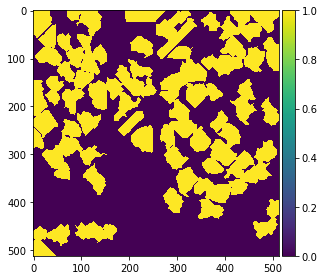

In [66]:
%matplotlib inline
plt.close("all")
#Reading in image
A0 = io.imread("../image_stacks/" + image_files[roi_idx], plugin="tifffile")
B0 = io.imread("../image_stacks/" + image_files[meas_idx], plugin="tifffile")
tif_section_len = 10 #Length of section of tif stack for each ROI detection
win = 10 #Window side length
full_final = np.zeros_like(A0[0])
roi_labels= []

for f in range(0,A0.shape[0],tif_section_len):
    if (f + tif_section_len) > A0.shape[0]:
        break
    tif_section = A0[f:f+tif_section_len]
    bright_image = np.empty((A0.shape[1],A0.shape[2]))
    for y in range(0,512,win):
        for x in range(0,512,win):
            max_box = np.zeros((win,win))
            for b in range(f,f+tif_section_len):
                box = A0[b,x:x+win,y:y+win]
                box_mean = np.mean(box)
                max_box_mean = np.mean(max_box)
                if box_mean > max_box_mean:
                    max_box = box
            bright_image[x:x+win,y:y+win] = max_box
    pre_gray_result = cv2.normalize(bright_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    gr_max = np.max(pre_gray_result)
    th, trunc_result = cv2.threshold(pre_gray_result, (.95 * gr_max), gr_max, cv2.THRESH_TRUNC)
    gray_result = cv2.bilateralFilter(trunc_result, 5, 80, 80)
    ret, test_binary = cv2.threshold(gray_result,np.min(gray_result),np.max(gray_result),cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_pre_result1 = cv2.bilateralFilter(test_binary, 2, 80, 80)
    binary_result = cv2.GaussianBlur(binary_pre_result1,(5,5),cv2.BORDER_DEFAULT)
    pre_mask = filters.median(binary_result)
    filled = ndi.binary_fill_holes(pre_mask)
    erode1 = skmorph.binary_erosion(filled)
    erode2 = skmorph.binary_erosion(erode1)
    mask = skmorph.remove_small_objects(erode2, min_size = 400)
    
    #Applying watershed transform to split touch objects
    dist = ndi.distance_transform_edt(mask)
    #Filtering distance transform
    h = .5
    h_maxima = skmorph.extrema.h_maxima(dist,h)
    coords = peak_local_max(h_maxima, min_distance = 12, exclude_border=False, footprint=np.ones((5,5)),labels=mask)
    watershed_mask = np.zeros(dist.shape, dtype=bool)
    watershed_mask[tuple(coords.T)] = True
    markers, _ = ndi.label(watershed_mask)
    labels = skseg.watershed(-dist,markers,mask=mask,watershed_line=True)
    
    #Closing edges
    eroded_water1 = skmorph.binary_erosion(labels)
    eroded_water2 = skmorph.binary_erosion(eroded_water1)
    pre_pre_final = skmorph.remove_small_objects(eroded_water2, min_size = 400)
    
    #Removing large objects
    size_label = skmeas.label(pre_pre_final)
    size_objs = skmeas.regionprops(size_label)
    pre_final = np.zeros_like(size_label)
    for obj in size_objs:
        if obj.area < 2000:
            pre_final = pre_final + (size_label == obj.label)
    check_label = skmeas.label(pre_final)
    check_objs = skmeas.regionprops(check_label)
    final_label = skmeas.label(full_final)
    final_objs = skmeas.regionprops(final_label)
    
    #Putting together "Composite" mask
    for obj in check_objs:
        ratio = obj.area / obj.perimeter
        if ratio < 6.0:
            continue
        unique = True
        obj_center = tuple(int(x) for x in obj.centroid)
        obj_coords = tuple((x[0],x[1]) for x in obj.coords)
        for final_obj in final_objs:
            final_obj_coords = tuple((x[0],x[1]) for x in final_obj.coords)
            final_obj_center = tuple(int(x) for x in final_obj.centroid)
            if len(obj_coords) > len(final_obj_coords): #If size of new object is larger than size of object it is being checked against (Final Object), check for overlap
                if len(list(set(final_obj_coords).intersection(obj_coords))) > 100: #If intersection between two regions is too high, eliminate final object
                    full_final = full_final - (final_label == final_obj.label)
                    for label in roi_labels:
                        if label.centroid == final_obj.centroid:
                            roi_labels.remove(label)
            else:
                if len(list(set(obj_coords).intersection(final_obj_coords))) > 100: #If new object is not larger than object it is being checked against, and overlap is present, new object is discarded
                    unique = False
                    break
        if unique == True:
            full_final = full_final + (check_label == obj.label)
            roi_labels.append(obj)
                              
movie_mask = np.zeros(full_final.shape, dtype=int)

for i in range(0,len(roi_labels)):
    for lab_x, lab_y in roi_labels[i].coords:
        movie_mask[lab_x,lab_y] = 1
full_final = movie_mask > 0
io.imshow(movie_mask)

In [67]:
# For removal of unwanted ROIs

# create modifiable index list for roi_labels
roi_labels_index = []
for n in range(1,len(roi_labels) + 1):
    roi_labels_index.append(n)
# create regions for removal widget
removal_widget = widgets.SelectMultiple(options=roi_labels_index[:], description='ROIs for Removal',
                            disabled=False, layout={'width':'175px', 'height':'120px'}, style={'description_width':'100px'})
def f(w1):
  global rois_removed
  rois_removed = removal_widget.value
display(widgets.interactive(f, w1=removal_widget))

interactive(children=(SelectMultiple(description='ROIs for Removal', layout=Layout(height='120px', width='175p…

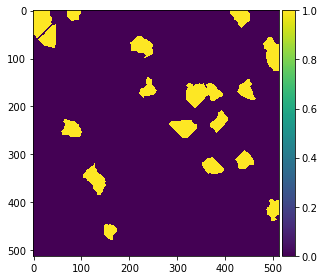

In [68]:
# For removal of unwanted ROIS 
%matplotlib inline
full_final = np.zeros_like(A0[0])
for c in sorted(rois_removed, reverse=True):
    del roi_labels[c-1]
for i in range(0,len(roi_labels)):
    for lab_x, lab_y in roi_labels[i].coords:
        full_final[lab_x,lab_y] = 1
io.imshow(full_final)

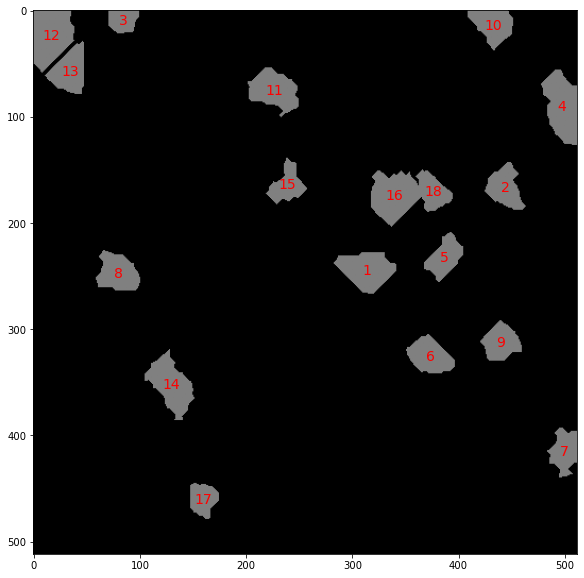

apical ROI labels:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
apical ROI pixel counts:  [1472, 997, 539, 1656, 914, 1092, 863, 1131, 951, 1029, 1358, 1741, 1114, 1532, 810, 1707, 670, 795]


In [69]:
#Label and ID ROIS *From John's Notebook*
movie_mask = np.zeros(full_final.shape, dtype=int)
for i in range(0,len(roi_labels)):
    for lab_x, lab_y in roi_labels[i].coords:
        movie_mask[lab_x,lab_y] = i + 1
#R, n = skmeas.label(full_final, return_num=True)
io.imsave(resultsdir + "/" + image_tags[meas_idx][0] + "-roi_mask_labelled.tif", np.int16(movie_mask), check_contrast=False) # Save labeled ROI Mask for movie
#ROI, COUNT = np.unique(label_test, return_counts=True)
COUNT = []
ROI = []
j = 1
for obj in roi_labels:
    #ratio = obj.area / obj.perimeter
    #print(str(ratio))
    ROI.append(j)
    COUNT.append(len(obj.coords))
    j += 1
#Plot labels of ROIS on image *From John's Notebook*
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 10])
ax.imshow(full_final, norm=None, vmax=2, cmap='gray') # dim the white a bit, easier to see the annnotations
i = 1
for props in roi_labels:
  y, x = props.centroid # get the centroid for each region
  t = ax.text(x, y, str(i), ha='center', va='center', size=14, c='r')
  i = i + 1
plt.show()
print("apical ROI labels: ", ROI[:])
print("apical ROI pixel counts: ", COUNT[:])

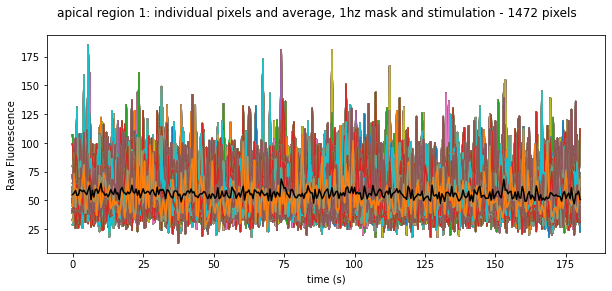

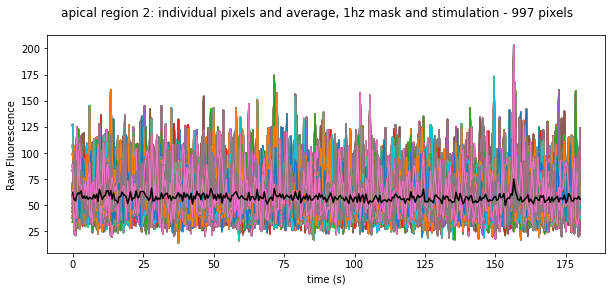

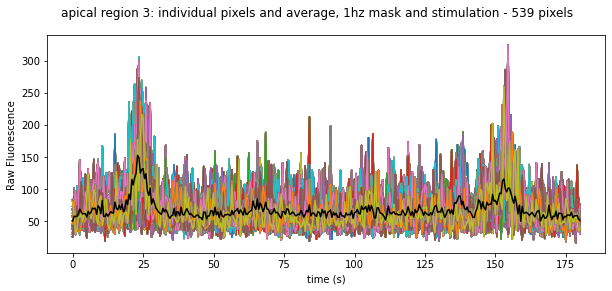

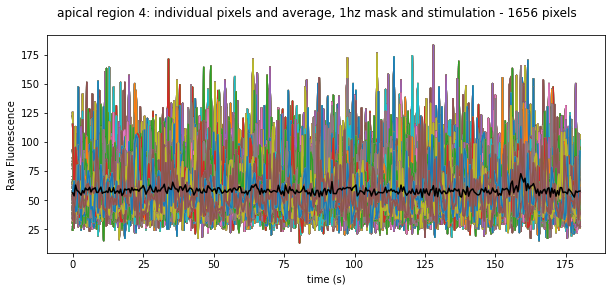

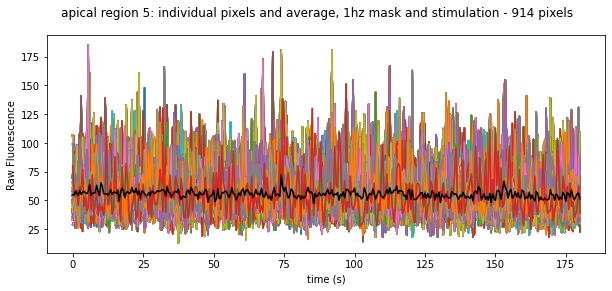

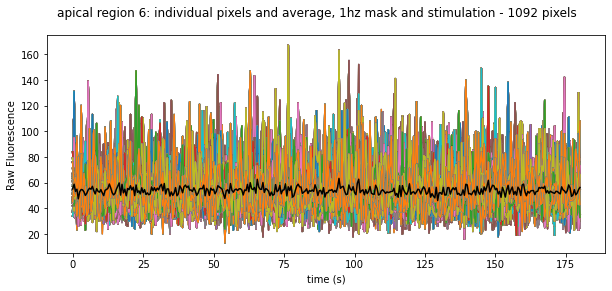

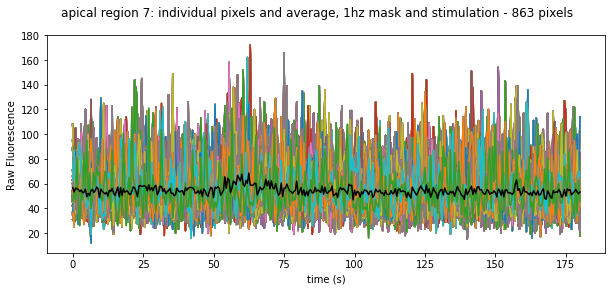

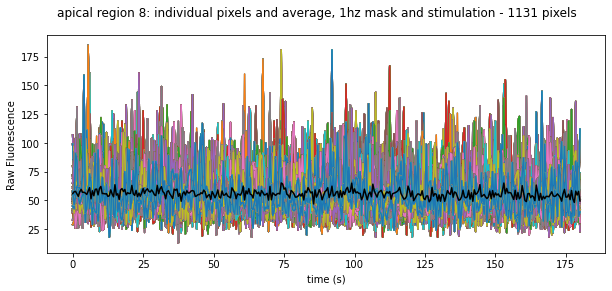

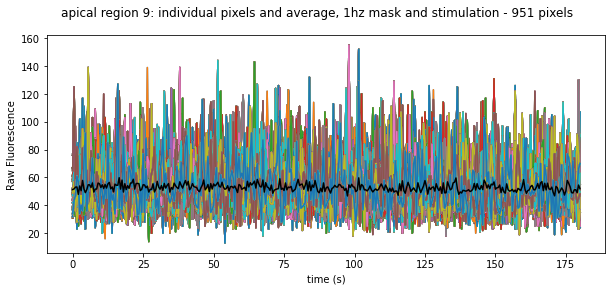

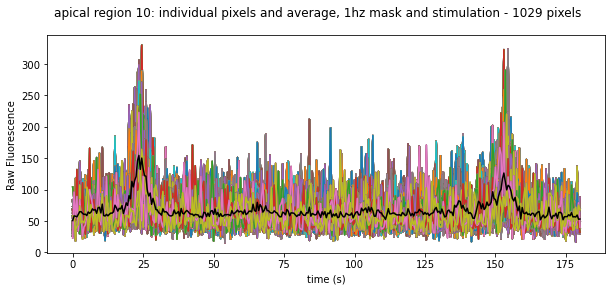

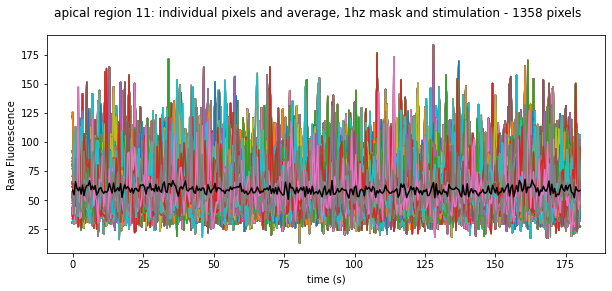

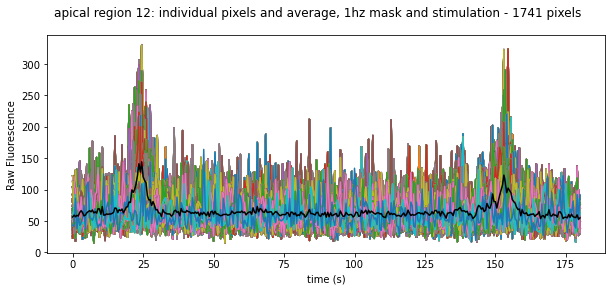

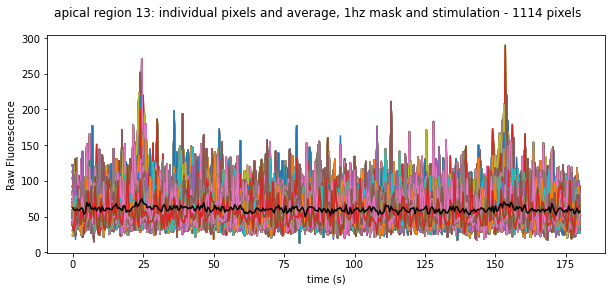

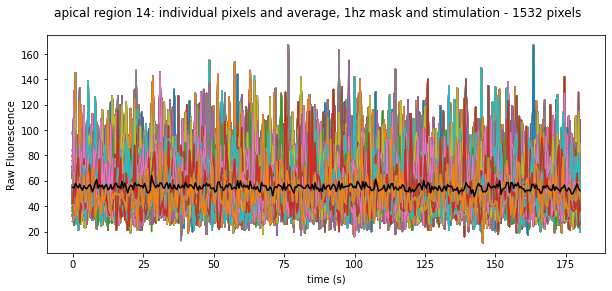

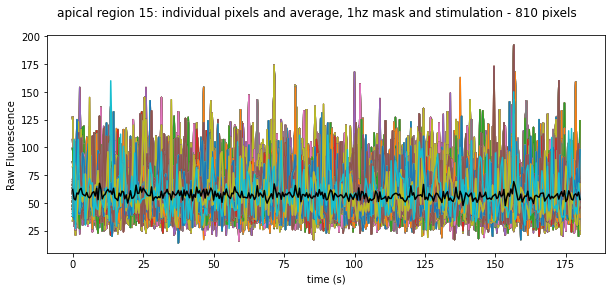

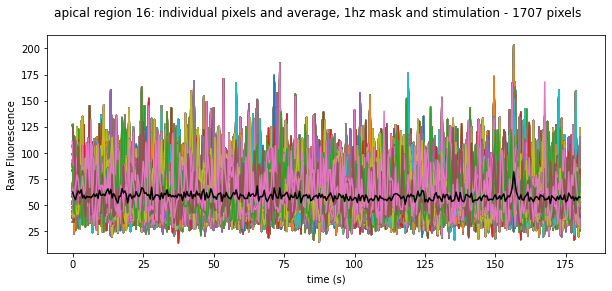

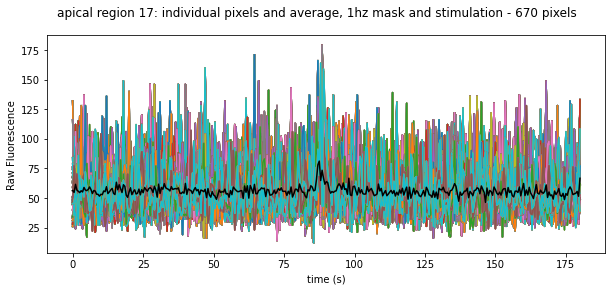

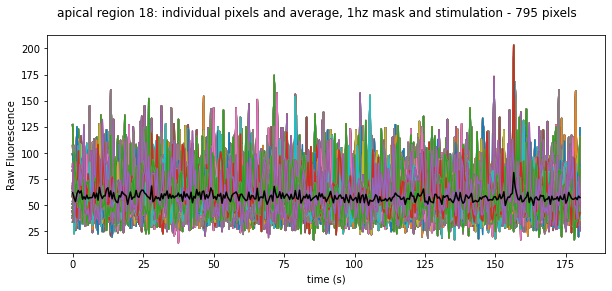

In [70]:
#Plotting region responses *From John's Notebook*
%matplotlib inline

# apical region plots using the mask
X = np.array(range(B0.shape[0])) * (1/image_fps) # the timebase

# create and save plots
for c in ROI:
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(c)+ ": individual pixels and average, " + image_tags[meas_idx][0] + " mask and stimulation - " +str(COUNT[c-1]) + " pixels")
  S = B0[:, roi_labels[c-1].coords]
  S = S[:,:,0,0] #Get rid of extra two dimensions at end of S
  T = np.sum(S, axis=1) / S.shape[1]
  ax.plot(X, S)
  ax.plot(X, T, color='black')
  ax.set(ylabel="Raw Fluorescence")
  ax.set(xlabel="time (s)")

  # save figure to pdf
  s = "/apical_region_" + str(c).zfill(2) + "-mask" + image_tags[meas_idx][0] + "-stim" + image_tags[meas_idx][0] + ".pdf"
  fig.savefig(resultsdir + s)
  
  plt.show()
  plt.close() # frees up memory


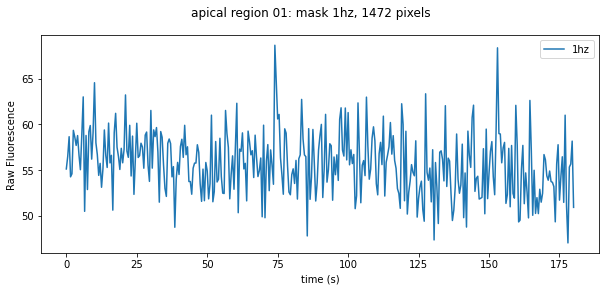

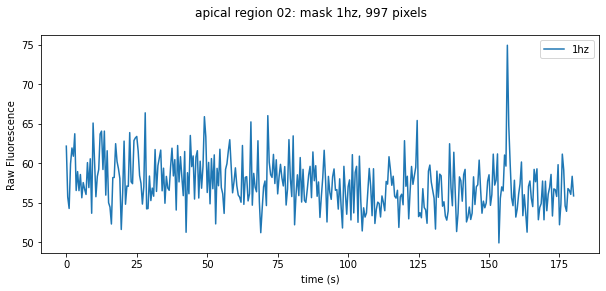

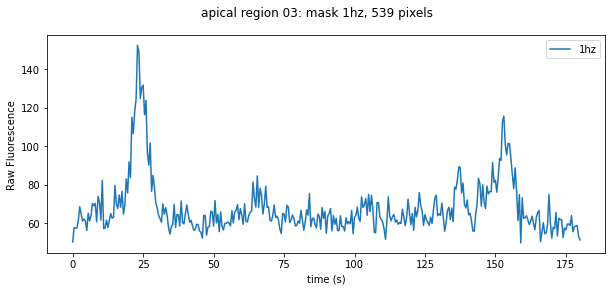

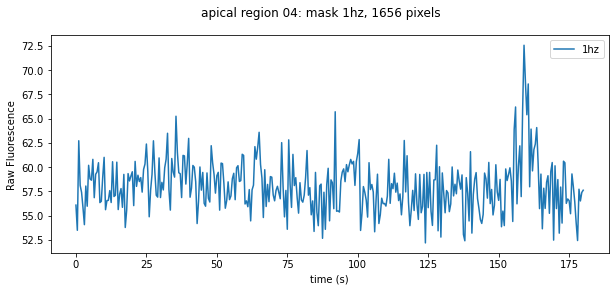

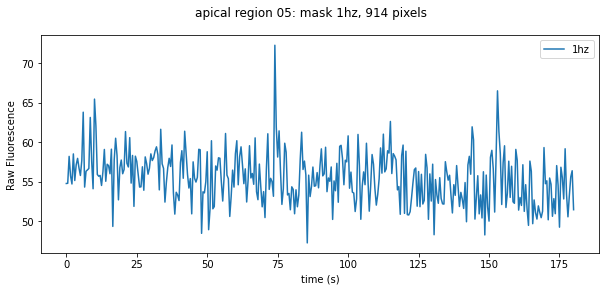

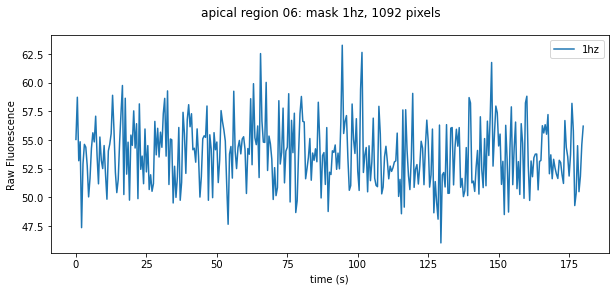

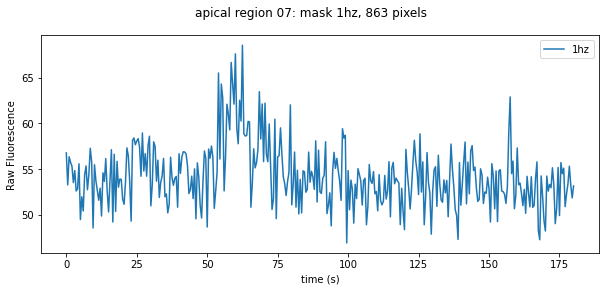

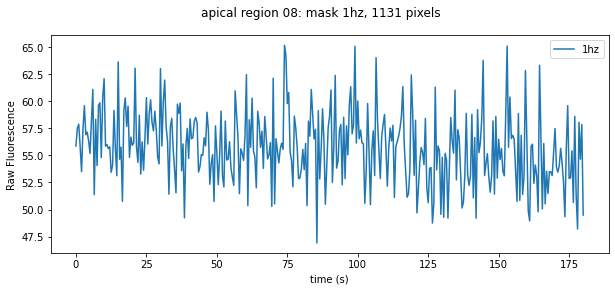

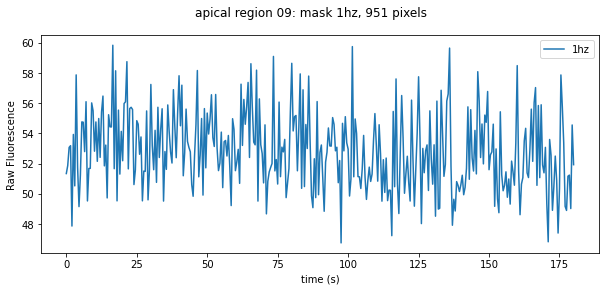

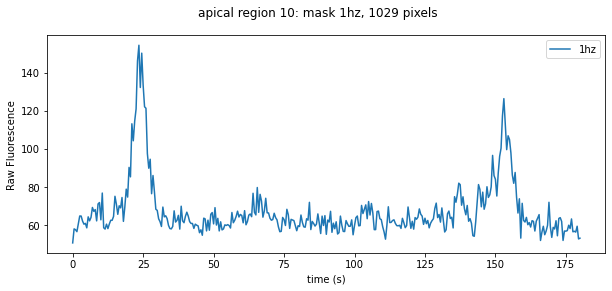

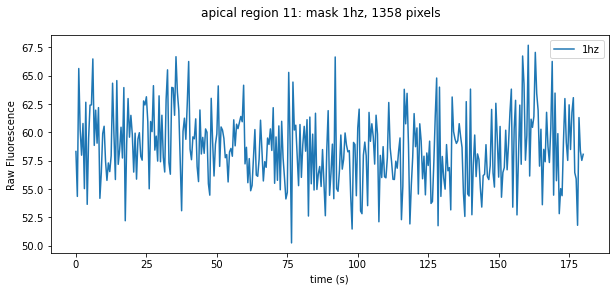

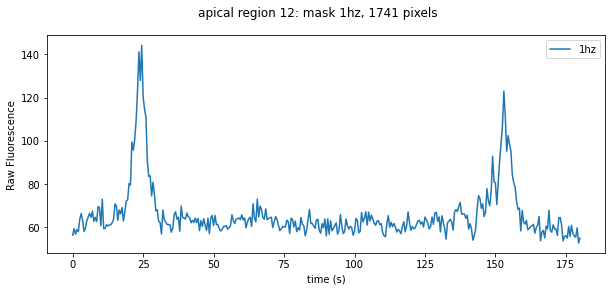

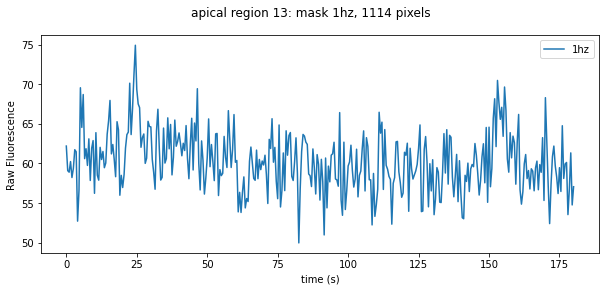

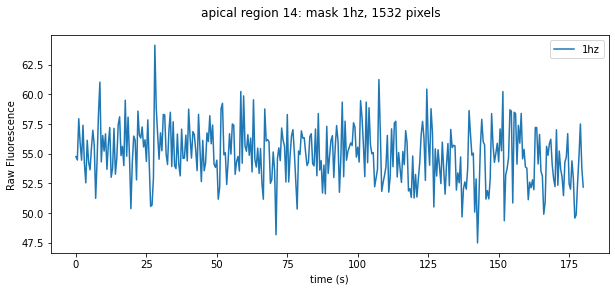

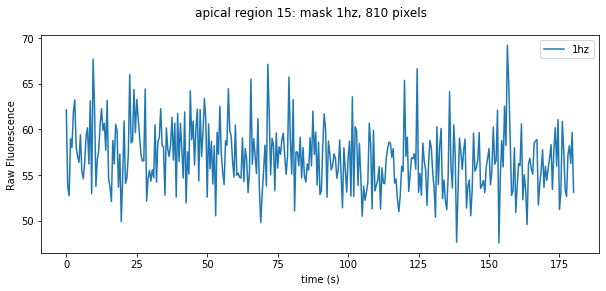

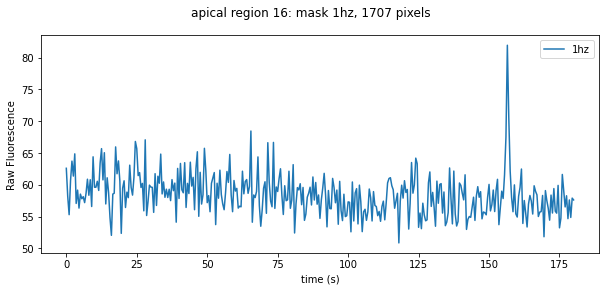

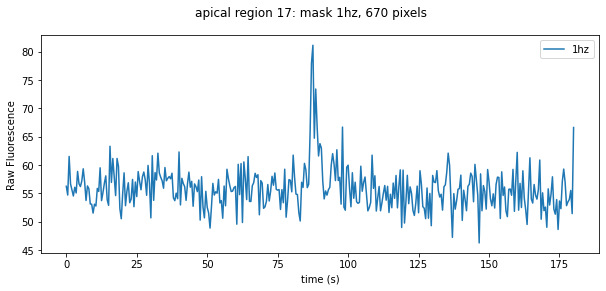

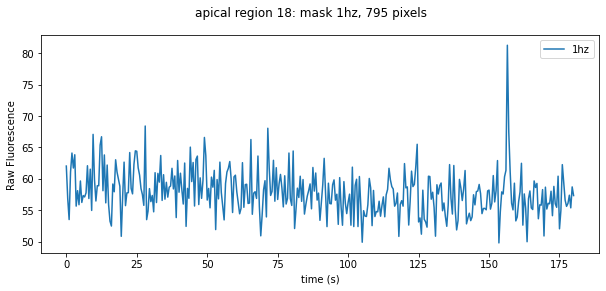

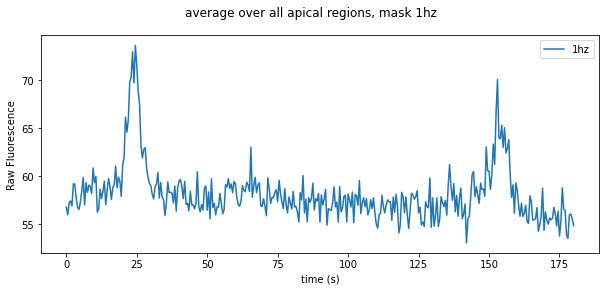

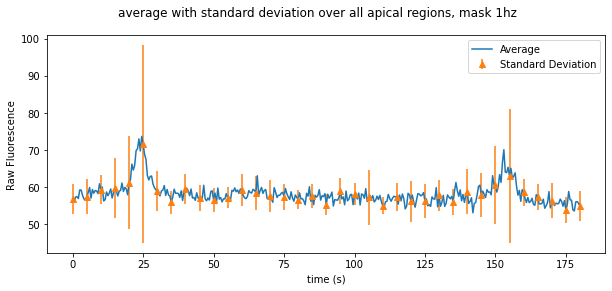

In [71]:
#Saving average graphs *From John's Notebook*
%matplotlib inline

# calculate, plot and save region responses for all stimulation frequencies

# calculate all of the results
RESULTS = np.zeros((1, len(ROI), B0.shape[0])) # array for all of the apical results
X = np.array(range(RESULTS.shape[2])) * (1/image_fps) # the timebase
f = image_files[meas_idx]
A0x = io.imread("../image_stacks/" + f)
for c in ROI:
    S = A0x[:, roi_labels[c-1].coords]
    S = S[:,:,0,0] #Get rid of extra two dimensions at end of S
    T = np.sum(S, axis=1) / S.shape[1]
    RESULTS[0, c-1] = T # save in the results array
# plot and save responses for all the stimulation frequencies by region
for n in range(0,len(ROI)):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(ROI[n]).zfill(2) + ": mask "+ image_tags[meas_idx][0] + ", " + str(COUNT[n]) + " pixels")

  ax.plot(X, np.transpose(RESULTS[:, n, :]))
  ax.set(ylabel="Raw Fluorescence")
  ax.set(xlabel="time (s)")
  ax.legend(image_tags[meas_idx])

  # save figure to pdf
  fig.savefig(resultsdir + "/apical_region_" + str(n+1).zfill(2) + "-mask" + image_tags[meas_idx][0] + "-stimALL.pdf")
    
  plt.show()
  plt.close() # frees up memory
  
  # save responses to CSV file
  with open (resultsdir + "/apical_region_" + str(n+1).zfill(2) + "-mask" + image_tags[meas_idx][0] + "-stimALL.csv", 'w') as file:
    writer = csv.writer(file)
    for i in range(RESULTS.shape[2]):
      t = np.append(X[i], RESULTS[:,n,i])
      writer.writerow('{:3.3e}'.format(x) for x in t)

# plot average of region responses for all the stimulation frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
fig.suptitle("average over all apical regions, mask "+ image_tags[meas_idx][0])

Y = np.transpose(np.sum(RESULTS, axis=(1)))/RESULTS.shape[1]
ax.plot(X, Y)
ax.set(ylabel="Raw Fluorescence")
ax.set(xlabel="time (s)")
ax.legend(image_tags[meas_idx])

# save figure to pdf
fig.savefig(resultsdir + "/apical_region_AVG-mask" + image_tags[meas_idx][0] + "-stimALL.pdf")
    
plt.show()
plt.close() # frees up memory

# save average of responses to CSV file
with open (resultsdir + "/apical_region_AVG-mask" + image_tags[meas_idx][0] + "-stimALL.csv", 'w') as file:
  writer = csv.writer(file)
  for i in range(X.shape[0]):
    t = np.append(X[i], Y[i])
    writer.writerow('{:3.3e}'.format(x) for x in t)

# save centroid coordinates of ROIs to CSV file for use in movie_maker
with open (resultsdir + "/roi_centroid_list.csv", 'w', newline='') as file:
  writer = csv.writer(file)
  for props in roi_labels:
      y, x = props.centroid # get the centroid for each region
      writer.writerow({float(x),float(y)})
 

#save total responses to single CSV file
total_list = []    
temp_list = []
for x in X: #Adding time step column
    temp_list.append(x)
total_list.append(temp_list[:])
temp_list.clear()
for c in ROI:
    f = image_files[meas_idx]
    A0x = io.imread("../image_stacks/" + f)
    if(c==0):
        continue
    S = A0x[:,roi_labels[c-1].coords]
    S = S[:,:,0,0] #Get rid of extra two dimensions at end of S
    T = np.sum(S, axis=1) / S.shape[1]
    for t in T:
        temp_list.append(t)
    total_list.append(temp_list[:]) #Append copy of temp list to total list
    temp_list.clear()    
std_df = pd.DataFrame(total_list) #Creating dataframe without average col, for std plotting

#Total responses single CSV file cont'd
for y in Y:
     temp_list.append(y[0])
total_list.append(temp_list[:])
df = pd.DataFrame(total_list).T  #Creating and transposing data frame so each region is its own column
df.to_csv("../image_stacks/" + image_tags[meas_idx][0] + "-stimALL.csv",
            index=False,header=False ) #Converting dataframe to csv file    
# creating separate averages results file
if not os.path.exists("../results_avgs"):
    os.mkdir("../results_avgs")
avgs_dir = "../results_avgs/"

# save average of responses to separate results file
with open (avgs_dir + "/results_avg_for" + image_tags[meas_idx][0] + ".csv", 'w') as file:
    writer = csv.writer(file)
    for i in range(X.shape[0]):
        t = np.append(X[i], Y[i])
        writer.writerow('{:3.3e}'.format(x) for x in t)

#Standard deviation calculations and graphing
std_df = std_df[1:] # removing time step row from dataframe
std = std_df.std(axis=0,skipna=True)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
fig.suptitle("average with standard deviation over all apical regions, mask "+ image_tags[meas_idx][0])
avg = []
for y in Y:
    avg.append(y) #Creating list of averages of measurement data
ax.plot(X, avg, label="Average") #Plotting average of measurement data
ax.errorbar(X[0::10],avg[0::10],std[0::10], linestyle='None', 
            marker='^', label="Standard Deviation") # std plotting of every 10th point's std
ax.set(ylabel="Raw Fluorescence")
ax.set(xlabel="time (s)")
ax.legend(loc = 'best')
plt.show()
plt.close()

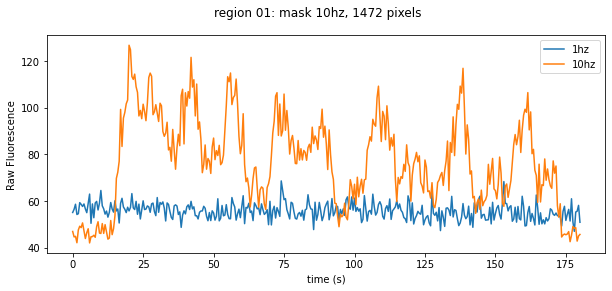

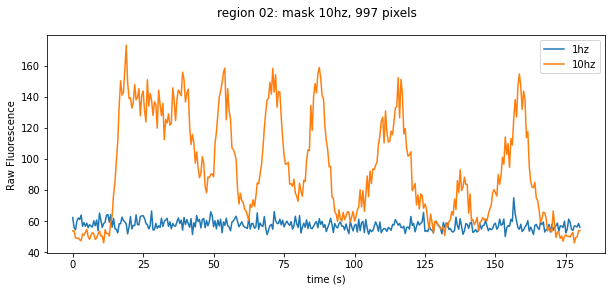

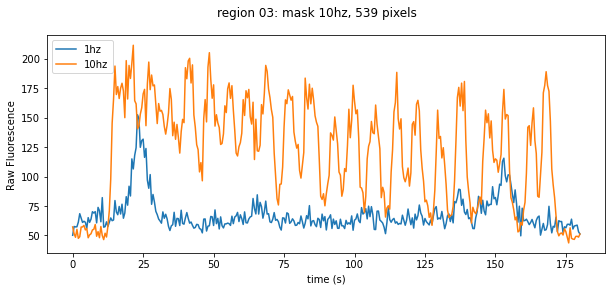

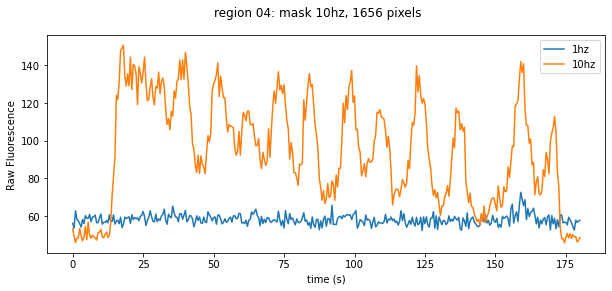

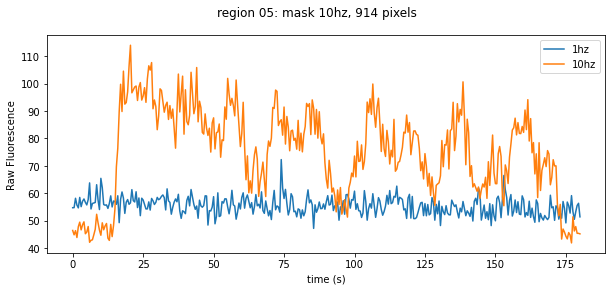

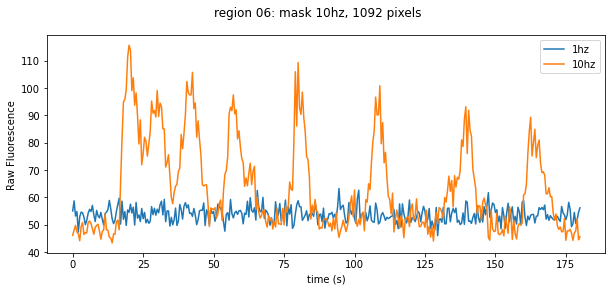

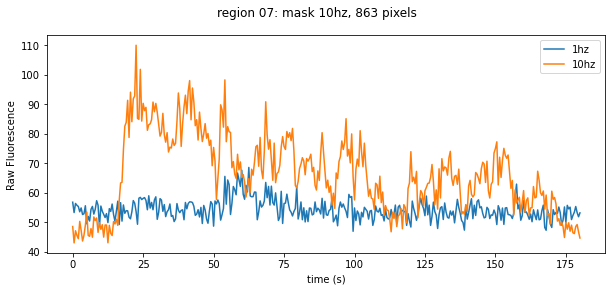

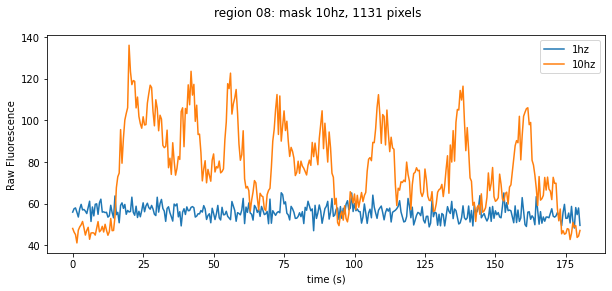

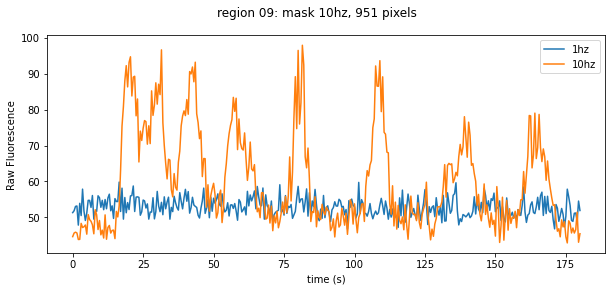

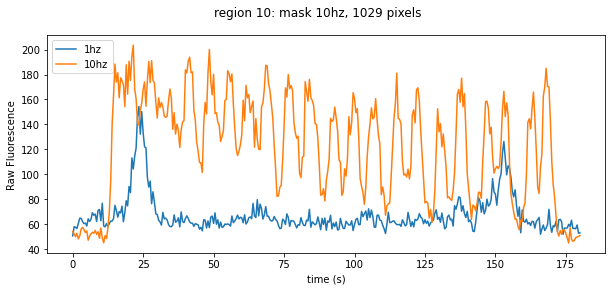

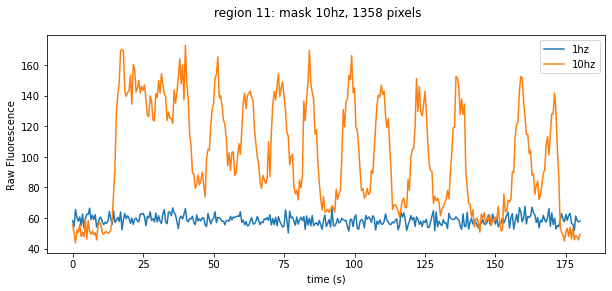

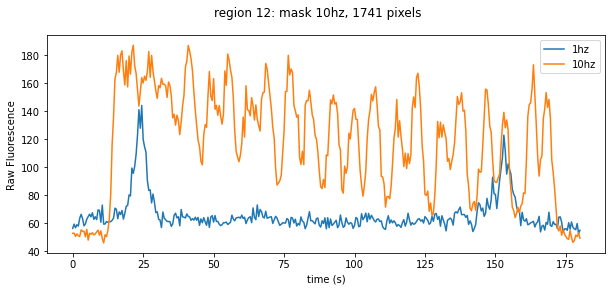

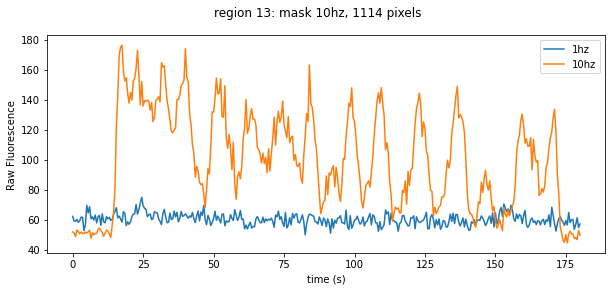

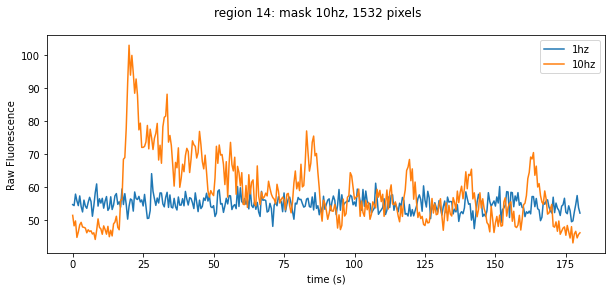

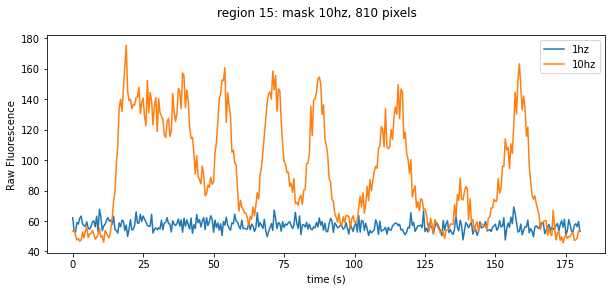

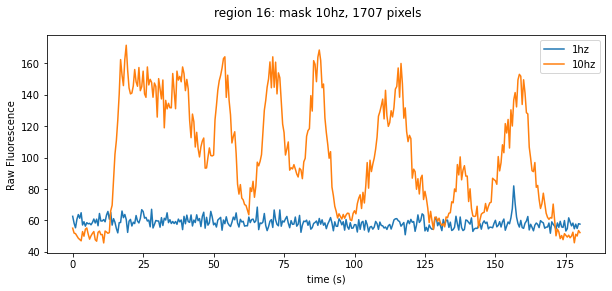

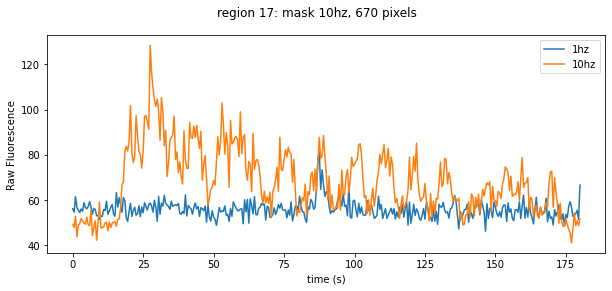

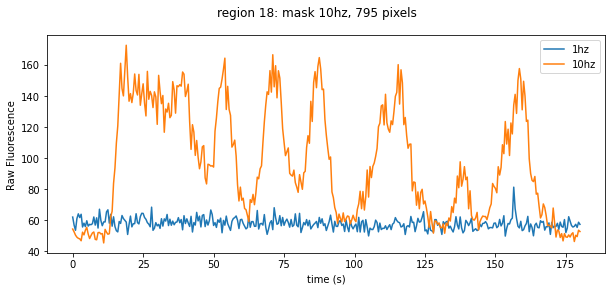

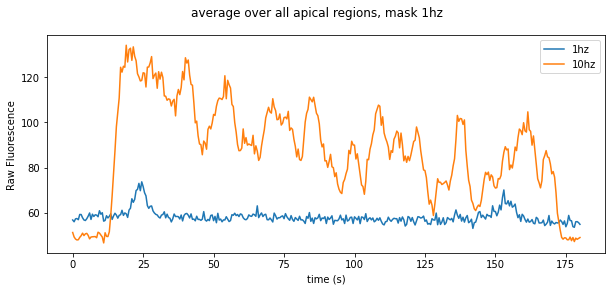

In [101]:
#Plotting Rest of image stacks selected, by ROI, on same graphs
TOTAL_RESULTS = np.zeros((len(image_files), len(ROI), A0.shape[0])) # array for all of the apical results
X = np.array(range(TOTAL_RESULTS.shape[2])) * (1/image_fps) # the timebase
for j in image_files:
    J0 = io.imread("../image_stacks/" + j)
    for c in ROI:
        if(c==0):
              continue
        S = J0[:, roi_labels[c-1].coords]
        S = S[:,:,0,0] #Get rid of extra two dimensions at end of S
        T = np.sum(S, axis=1) / S.shape[1]
        TOTAL_RESULTS[list(image_files).index(j), c-1] = T # save in the results array
        
 # plot and save responses for all the stimulation frequencies by region
for n in range(1,len(ROI)+1):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('region ' + str(ROI[n-1]).zfill(2) + ": mask "+ image_tags[roi_idx][0] + ", " + str(COUNT[n-1]) + " pixels")
  ax.plot(X, np.transpose(TOTAL_RESULTS[:, n-1, :]))
  ax.set(ylabel="Raw Fluorescence")
  ax.set(xlabel="time (s)")
  ax.legend([t[0] for t in image_tags][0:len(image_files)])   
  # save figure to pdf
  fig.savefig(resultsdir + "/region_" + str(n).zfill(2) + "-mask" + image_tags[roi_idx][0] + "-FULL_STACK.pdf")
  plt.show()
  plt.close() # frees up memory
    
    # plot and save avg responses for all the stimulation frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
fig.suptitle("average over all apical regions, mask "+ image_tags[meas_idx][0])
for j in range(0,len(image_files)-1):
    Y = np.transpose(np.sum(TOTAL_RESULTS, axis=(1)))/TOTAL_RESULTS.shape[1]
    ax.plot(X, Y)
    ax.set(ylabel="Raw Fluorescence")
    ax.set(xlabel="time (s)")
    ax.legend([t[0] for t in image_tags][0:len(image_files)])   
fig.savefig(resultsdir + "/mask_" + image_tags[roi_idx][0] + "-FULL_STACK_AVERAGES.pdf")
plt.show()
plt.close()